In [1]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd
import umap

from scCustomFunctions import *
from parameters import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
a = loadData(QC_imputed=True,Normalized=True,Log1p=True)

# Compute corrections

We compute batch corrections using two different algorithms

1. Harmony
2. Fast MNN (MNN algorithm used on the first 50 pcs)

**Results:** Raw data shows that it is required to batch correct the datasets. Fast MNN has not been able to integrate all the datasets. On the other hand, Harmony has manage to do it with an appropiate mixing.

2021-07-27 15:07:06,218 - harmonypy - INFO - Iteration 1 of 10
2021-07-27 15:07:06,628 - harmonypy - INFO - Iteration 2 of 10
2021-07-27 15:07:06,978 - harmonypy - INFO - Iteration 3 of 10
2021-07-27 15:07:07,326 - harmonypy - INFO - Iteration 4 of 10
2021-07-27 15:07:07,725 - harmonypy - INFO - Iteration 5 of 10
2021-07-27 15:07:08,152 - harmonypy - INFO - Iteration 6 of 10
2021-07-27 15:07:08,389 - harmonypy - INFO - Iteration 7 of 10
2021-07-27 15:07:08,621 - harmonypy - INFO - Iteration 8 of 10
2021-07-27 15:07:08,786 - harmonypy - INFO - Iteration 9 of 10
2021-07-27 15:07:08,918 - harmonypy - INFO - Iteration 10 of 10
2021-07-27 15:07:09,039 - harmonypy - INFO - Converged after 10 iterations


NameError: name 'l' is not defined

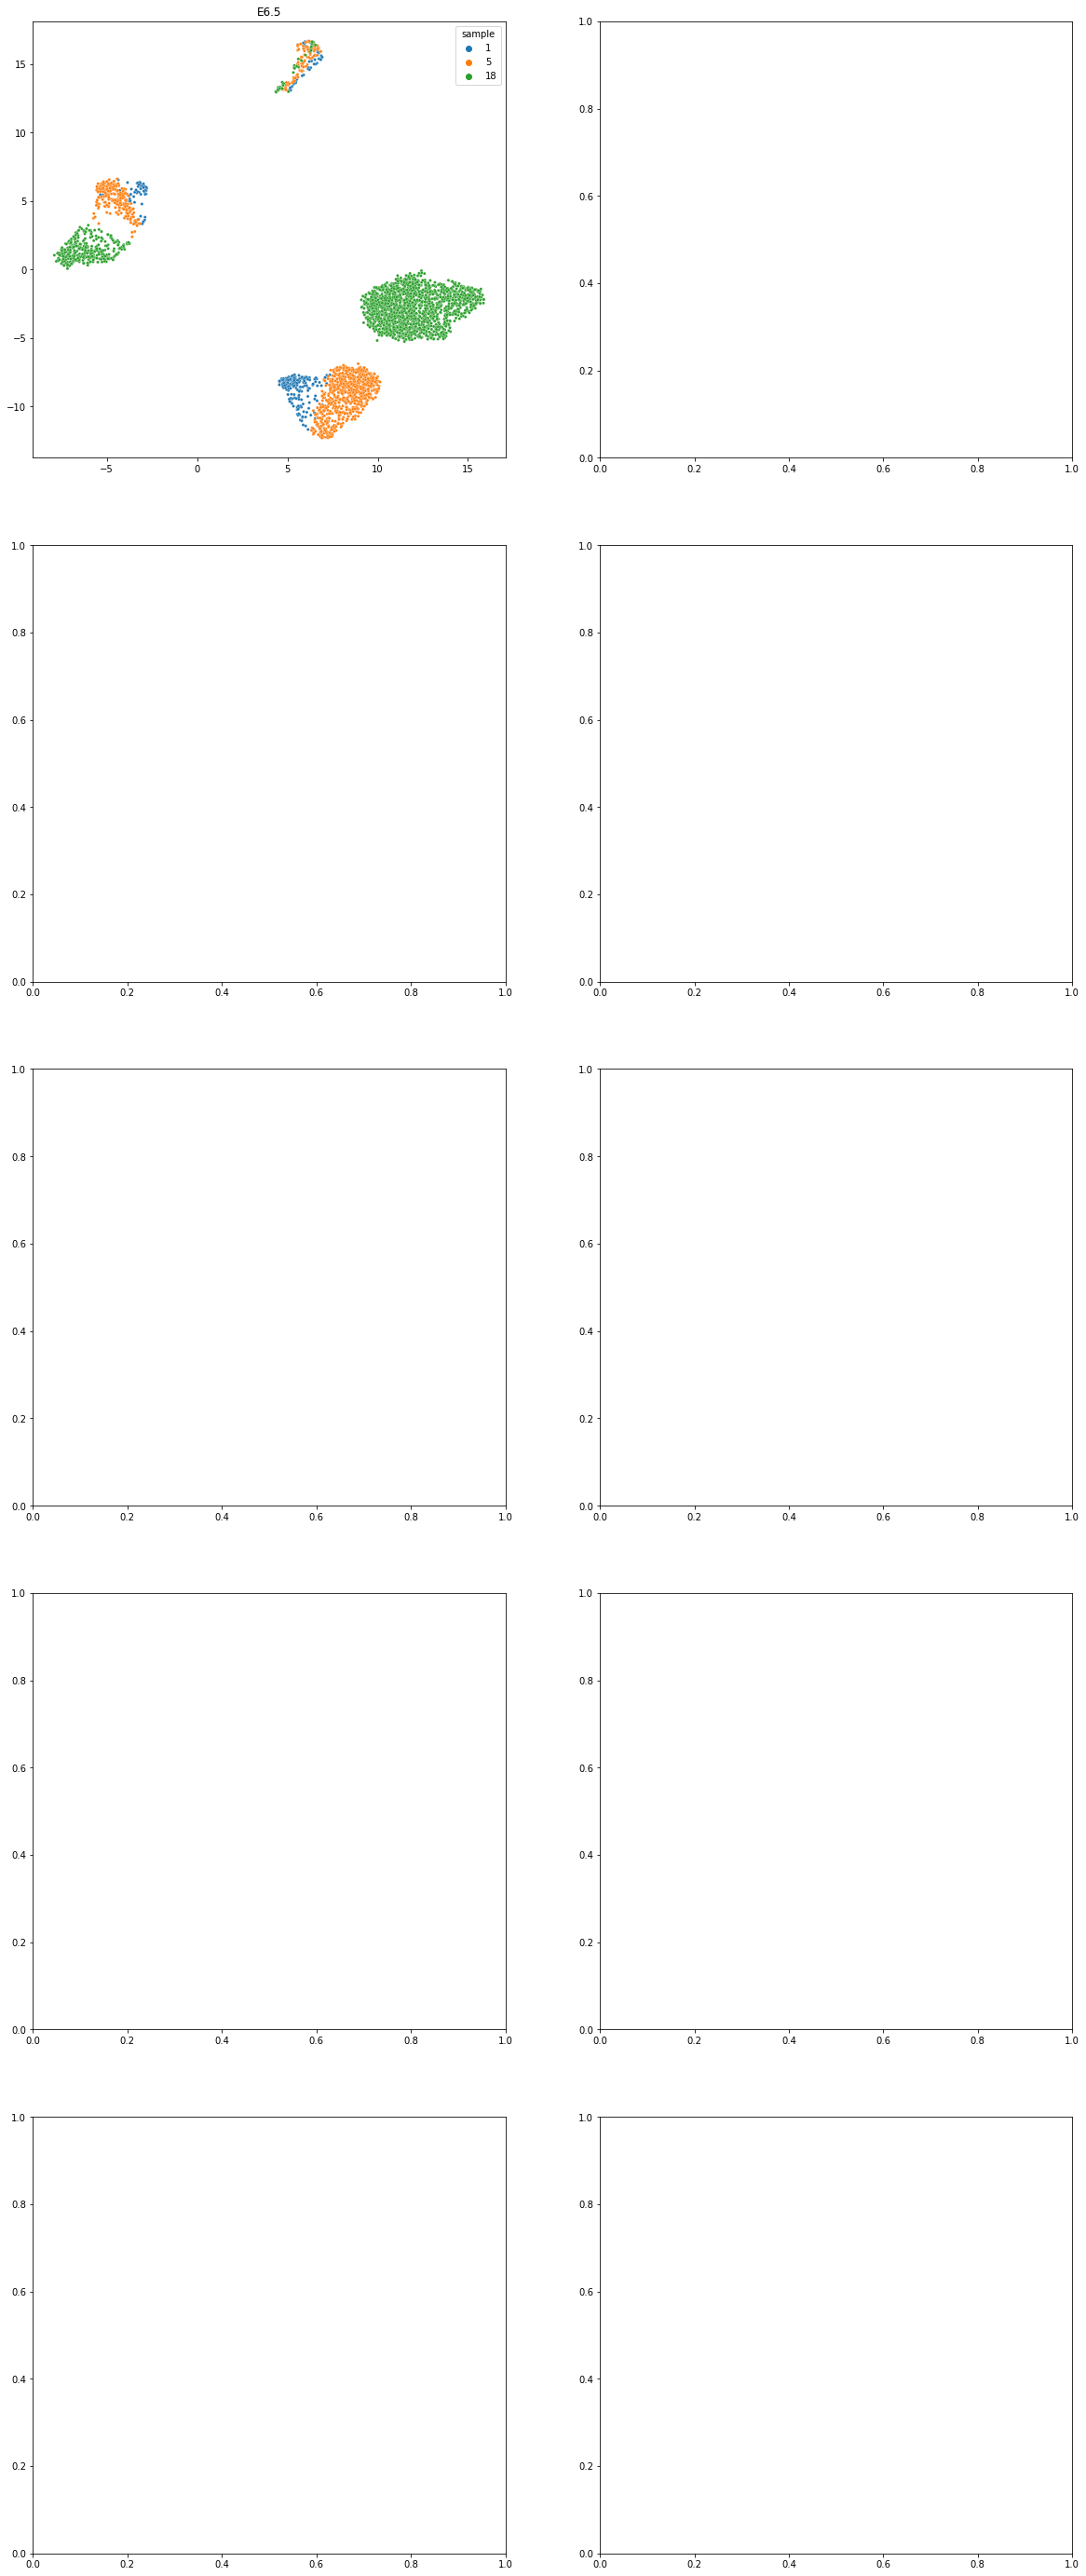

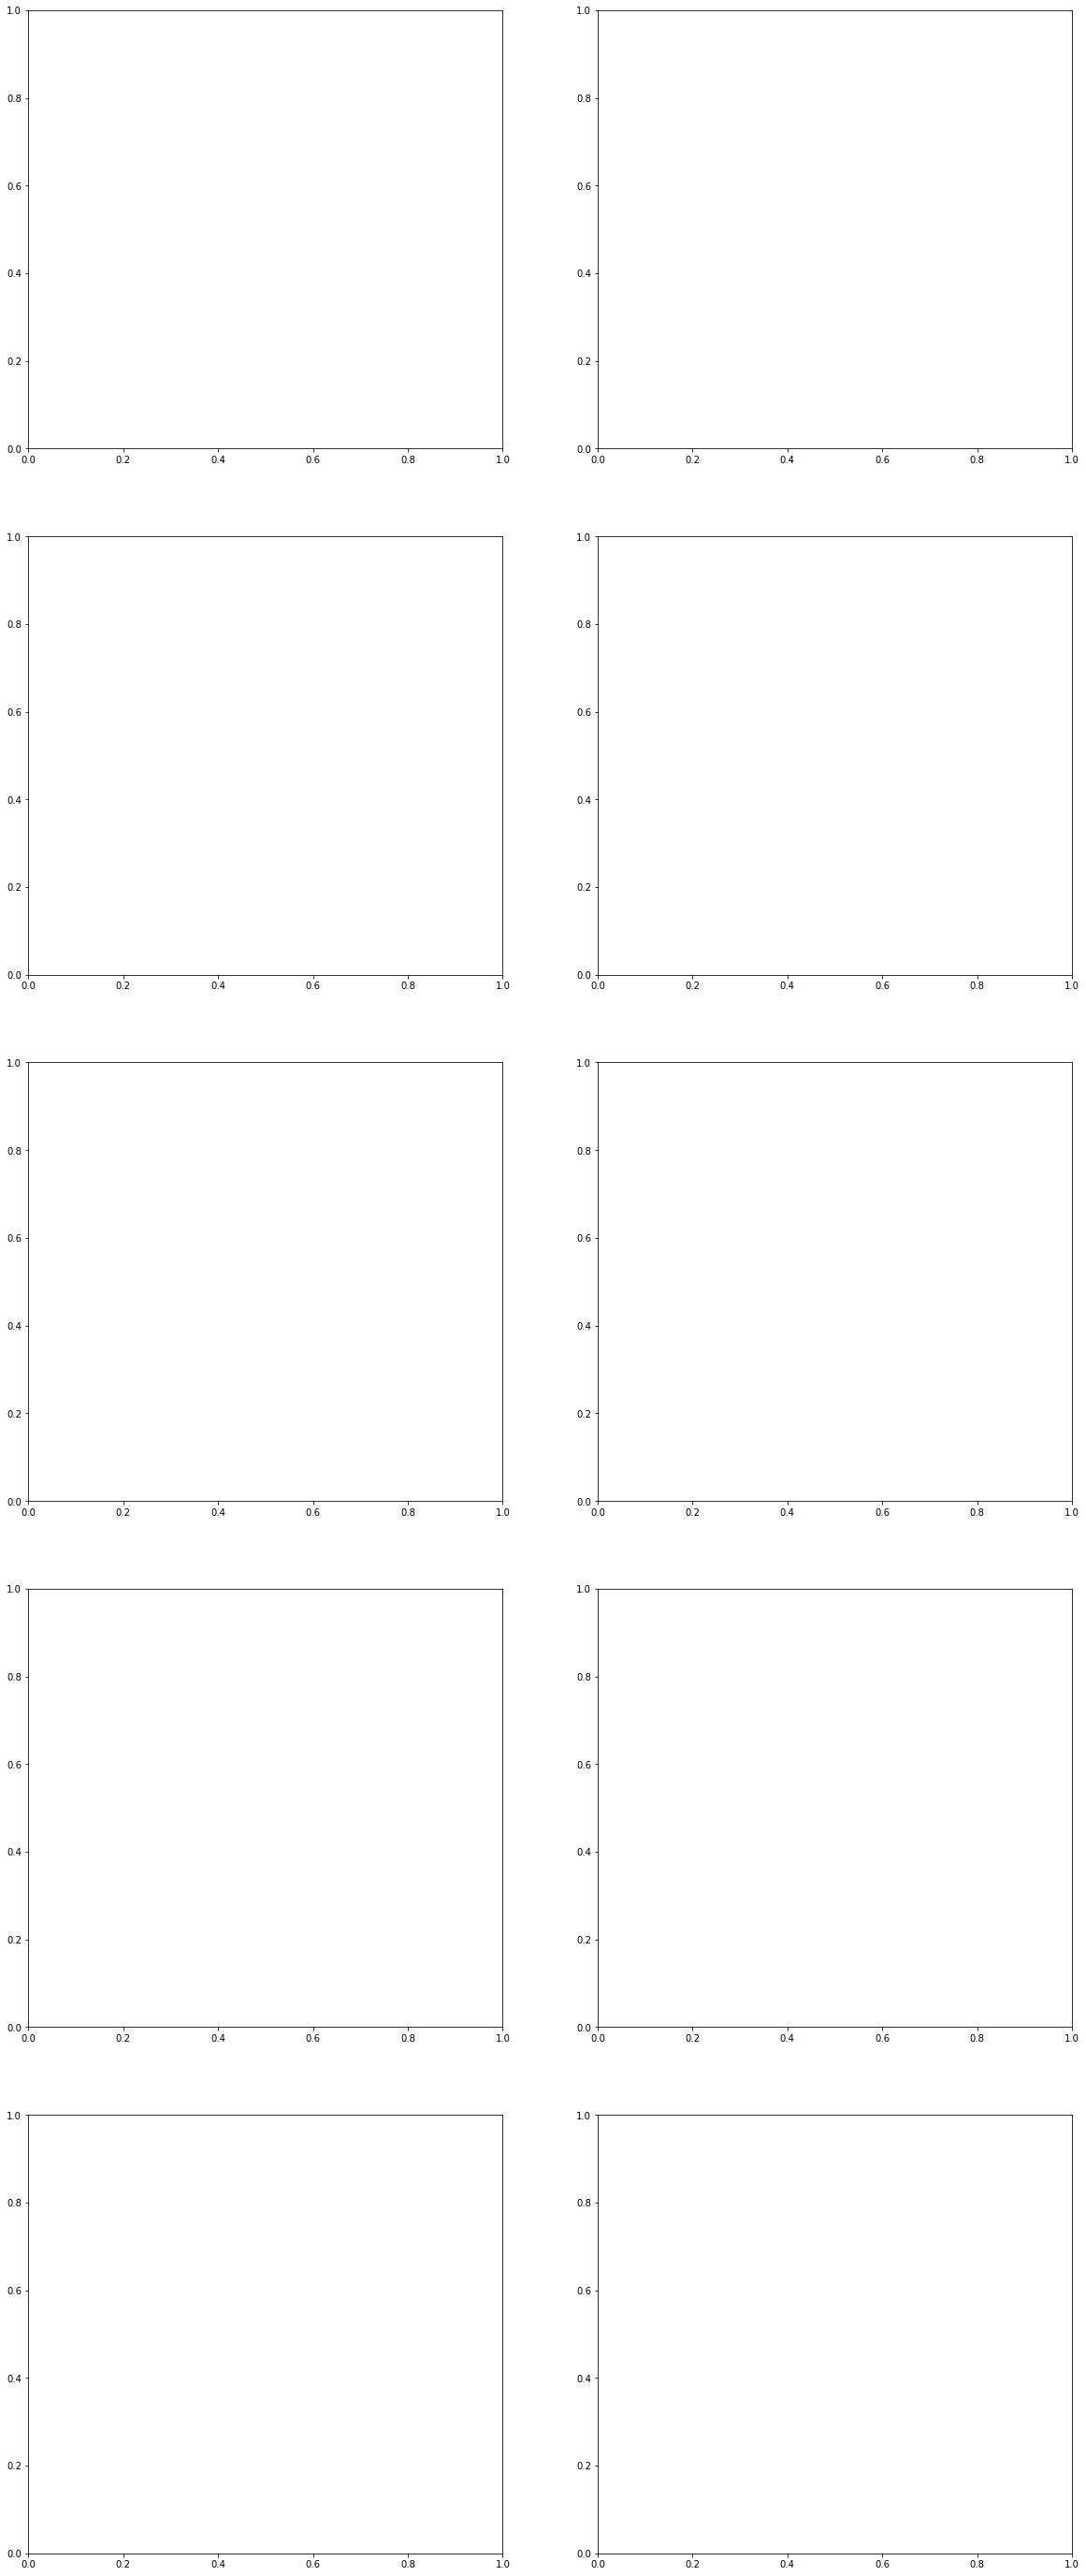

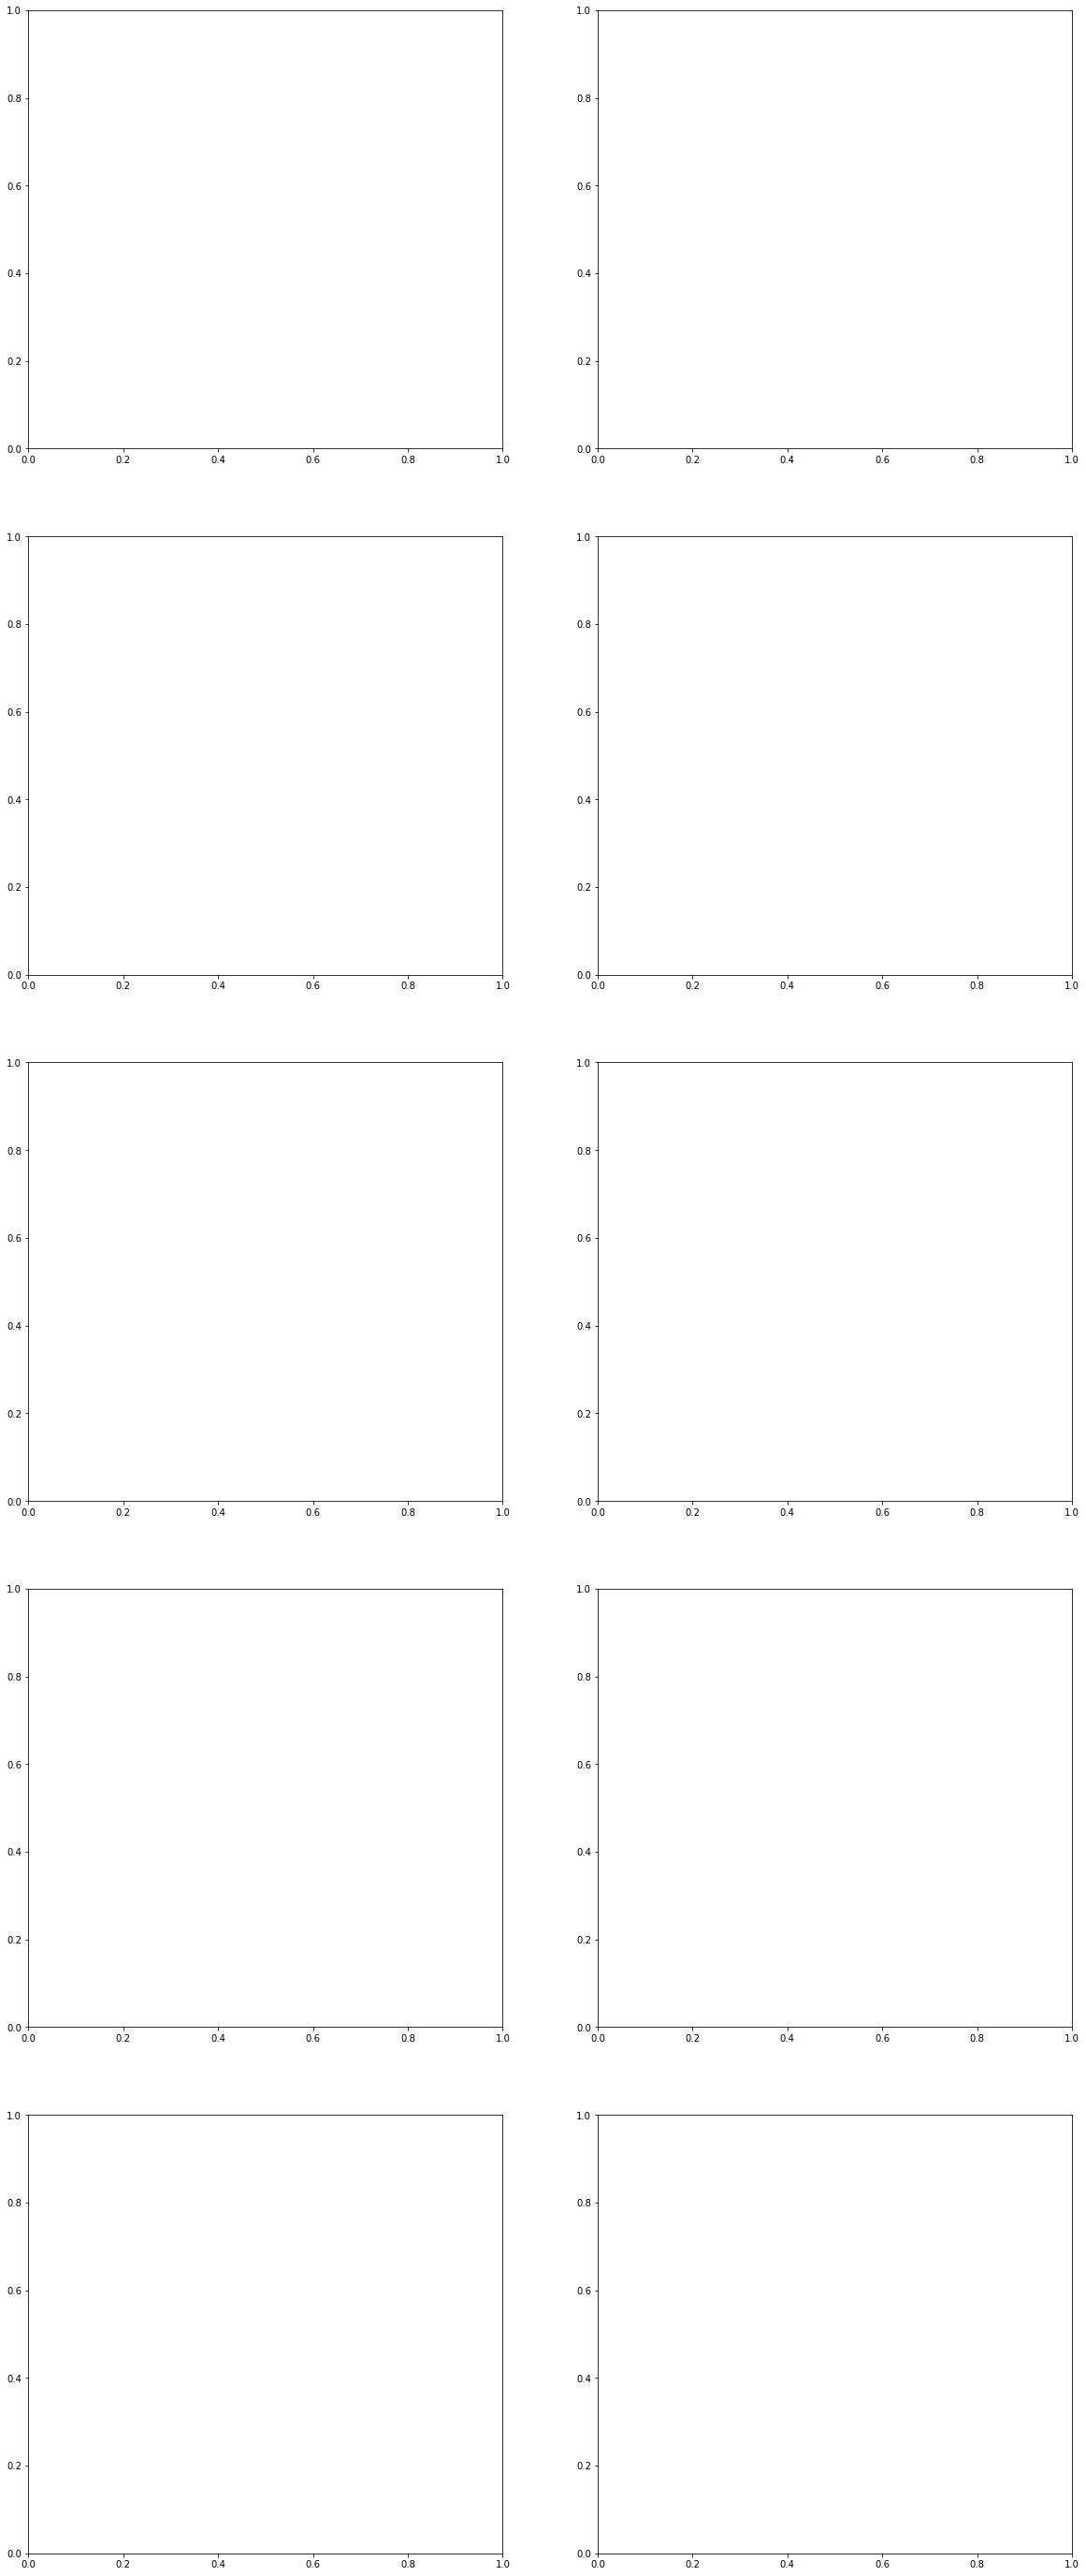

In [4]:
fig1,ax1 = plt.subplots(5,2,figsize=[20,50])
fig2,ax2 = plt.subplots(5,2,figsize=[20,50])
fig3,ax3 = plt.subplots(5,2,figsize=[20,50])
for j,stage in enumerate(np.sort(a.obs["stage"].unique())):
    
    posx = j//2
    posy = j%2

    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    b.obs["sample"]=b.obs["sample"].astype(str)
    scp.pp.highly_variable_genes(b,flavor=HVG_METHOD)
    remove_highly_variable_genes(b,SKIP_GENES) #Remove genes related with sex or cell cycle
    
    #Raw
    scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS)

#     umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
#     scp.tl.umap(b,init_pos="paga")
    scp.tl.umap(b)
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage)
    
    np.save("dataOut/4_Batch_Correction/PCA_"+stage,b.obsm["X_pca"])
    np.save("dataOut/4_Batch_Correction/UMAP_"+stage,b.obsm["X_umap"])
    
    #Harmony
    scp.external.pp.harmony_integrate(b,"sample")
    l.append(b.obsm["X_pca_harmony"].copy())
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_harmony")

#     umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
#     scp.tl.umap(b,init_pos="paga")
    scp.tl.umap(b)
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax2[posx,posy])
    ax2[posx,posy].set_title(stage)

    np.save("dataOut/4_Batch_Correction/PCA_harmony_"+stage,b.obsm["X_pca_harmony"])
    np.save("dataOut/4_Batch_Correction/UMAP_harmony_"+stage,b.obsm["X_umap"])
    
    #MNN Some bug on the method and cannot be installed
    fast_mnn_correct(b,"sample",k=N_NEIGBOURS)
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_MNN")
    
#     umap_seed_with_paga(b,LOUVAIN_INITIALISATION)
#     scp.tl.umap(b,init_pos="paga")
    scp.tl.umap(b)
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax3[posx,posy])
    ax3[posx,posy].set_title(stage)

    np.save("dataOut/4_Batch_Correction/PCA_mnn"+stage+".png",b.obsm["X_pca_MNN"])
    np.save("dataOut/4_Batch_Correction/UMAP_mnn"+stage+".png",b.obsm["X_umap"])
    
fig1.savefig("Plots/4_Batch_Correction/Stages_without_correction_umap.png",bbox_inches="tight",transparent=True)
fig2.savefig("Plots/4_Batch_Correction/Stages_Harmony_umap.png",bbox_inches="tight",transparent=True)
fig3.savefig("Plots/4_Batch_Correction/Stages_MNN_umap.png",bbox_inches="tight",transparent=True)